In [1]:
import json
import os
import posixpath
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import requests
import unidecode
from goose3 import Goose
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTModel
from transformers import BertTokenizer, RobertaModel
import matplotlib.pyplot as plt

In [2]:
def resolveComponents(url):
    """
     resolveComponents('http://www.example.com/foo/bar/../../baz/bux/')
    'http://www.example.com/baz/bux/'
     resolveComponents('http://www.example.com/some/path/../file.ext')
    'http://www.example.com/some/file.ext'
    """

    parsed = urlparse(url)
    new_path = posixpath.normpath(parsed.path)
    if parsed.path.endswith('/'):
        # Compensate for issue1707768
        new_path += '/'
    cleaned = parsed._replace(path=new_path)

    return cleaned.geturl()

def clean_article(item, article):
    def clean_text(text):
        text = text.strip()
        text = text.replace('“', '"').replace('”', '"')
        text = text.replace("‘", "'").replace("’", "'")
        return text

    abstract = item['abstract']
    caption = item['caption']
    article = clean_text(article)

    tips = 'As a subscriber, you have 10 gift articles to give each month. Anyone can read what you share.'
    article_cleaned = article.replace(abstract, '').replace(caption, '').replace(tips, '')
    while True:
        if article_cleaned.startswith('\n'):
            article_cleaned = article_cleaned[1:]
        else:
            break

    return article_cleaned

def download_image(item):
    img_data = requests.get(item['image_url'], stream=True).content
    with open(os.path.join("Data/N24New/imgs/%s.jpg" % (item['image_id'])), 'wb') as f:
        f.write(img_data)

def download_article(item):
    url = resolveComponents(item['article_url'])
    extract = g.extract(url=url)
    article = unidecode.unidecode(extract.cleaned_text)
    return article

def del_dir(path):
    for i in os.listdir(path):  # os.listdir(path_data)#返回一个列表，里面是当前目录下面的所有东西的相对路径
        file_data = path + '/' + i  # 当前文件夹的下面的所有东西的绝对路径
        if os.path.isfile(file_data):  # os.path.isfile判断是否为文件,如果是文件,就删除.如果是文件夹.递归给del_file.
            os.remove(file_data)

In [3]:
# g = Goose()
# if os.path.exists('Data/N24New/images'):
#     del_dir('Data/N24New/images')
# else:
#     os.makedirs('Data/N24New/images')
j = json.load(open('Data/N24New/news/nytimes_train.json', 'r', encoding='utf8'))
j

[{'section': 'Theater',
  'headline': "Before 'Moonlight' and 'The Walking Dead,' a Friendship Born in the Classroom",
  'article_url': 'https://www.nytimes.com/2017/02/21/theater/danai-gurira-andre-holland-walking-dead.html',
  'article': 'Danai Gurira and Andre Holland in a theater at New York University, where they met in the Tisch Graduate Acting Program.\n\nBehind every successful person are relationships that helped forge a path. But the stories of these friendships, collaborations, alliances, romances or rivalries often are lost in the glow of achievement. In this new feature, we explore a personal connection that made a difference in the lives of two artists. Andre Holland never thought much about writing his own monologues when he attended the Tisch graduate acting program at New York University. But one day, early in his first semester in 2003, he watched another African-American student, Danai Gurira, forgo the usual speeches by white characters and perform her own material 

In [4]:
# convert j to dataframe while collumns are image_id, headline, abstract, caption, section
df = pd.DataFrame(j)
df = df[['image_id', 'headline', 'abstract', 'caption', 'section']]
df

image_id  \
0      952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1      67b1b62f-43ea-59d0-bf93-a94c11845820   
2      3da821ea-b93b-5a09-99d7-45e1711b73f0   
3      becf4474-d1fa-5722-b829-251530aa942b   
4      9511a127-e616-5bf5-80c6-553da4010c19   
...                                     ...   
48983  edbd14e2-9f6e-588d-9b98-8c54541d2865   
48984  11b2f98a-45a2-5109-8b4f-5b8fb1e9e2f4   
48985  5c469e7a-a39b-5248-9fac-4f289c78a7cb   
48986  4074ae02-c26f-57cf-b32e-4e61fd334a99   
48987  c5e949c4-5166-5f84-8894-c6e3c26b0f08   

                                                headline  \
0      Before 'Moonlight' and 'The Walking Dead,' a F...   
1      What's on TV Wednesday: 'Crip Camp' and 'Dark ...   
2      Rays Stick to Their Plan and Reach a 2nd World...   
3        For Robert Rauschenberg, No Artist Is an Island   
4      Jimmy Buffett's 'Margaritaville' Musical Sets ...   
...                                                  ...   
48983         Recent Commercial Real Estate Transactions   
48984  Volvo Recalls 31,000 Cars for Oil Pressure Sen...   
48985                    A Family Sedan for the Speedway   
48986  Lessons From 2016 for the News Media, as the G...   
48987          New York Galleries: What to See Right Now   

                                                abstract  \
0      André Holland first saw Danai Gurira at New Yo...   
1      The documentary "Crip Camp: A Disability Revol...   
2      Guided by the club's strict principles, Manage...   
3      A writer travels from Brooklyn to Lafayette, L...   
4      "Escape to Margaritaville," which features new...   
...                                                  ...   
48983  Recent commercial real estate transactions in ...   
48984  When a mechanic forgot to put oil in a Volvo S...   
48985  The 2015 Charger Hellcat will have the same su...   
48986  A presidential race that made fools of pundits...   
48987  Joseph Elmer Yoakum's delirious vistas; Olga B...   

                                                 caption       section  
0      Danai Gurira and André Holland in a theater at...       Theater  
1      Judy Heumann in &ldquo;Crip Camp: A Disability...    Television  
2      The Rays celebrated after the final out of the...        Sports  
3      Robert Rauschenberg performing in "Pelican" in...  Art & Design  
4      Jimmy Buffett, performing in 2016. His musical...       Theater  
...                                                  ...           ...  
48983  This building in Bushwick has two residential ...   Real Estate  
48984                                The 2012 Volvo S60.   Automobiles  
48985      Dodge says Charger Hellcat can hit 204 m.p.h.   Automobiles  
48986  President-elect Donald J. Trump after meeting ...         Media  
48987  Joseph Elmer Yoakum&rsquo;s &ldquo;Mt Horsebac...  Art & Design  

[48988 rows x 5 columns]

In [5]:
# concat headline, abstract, caption
df['article'] = df['headline'] + '. ' + df['abstract'] + '. ' + df['caption']
df = df.drop(columns=['headline', 'abstract', 'caption'])
df

image_id       section  \
0      952a8b15-63f6-5e41-8f23-82dfbb33d1fa       Theater   
1      67b1b62f-43ea-59d0-bf93-a94c11845820    Television   
2      3da821ea-b93b-5a09-99d7-45e1711b73f0        Sports   
3      becf4474-d1fa-5722-b829-251530aa942b  Art & Design   
4      9511a127-e616-5bf5-80c6-553da4010c19       Theater   
...                                     ...           ...   
48983  edbd14e2-9f6e-588d-9b98-8c54541d2865   Real Estate   
48984  11b2f98a-45a2-5109-8b4f-5b8fb1e9e2f4   Automobiles   
48985  5c469e7a-a39b-5248-9fac-4f289c78a7cb   Automobiles   
48986  4074ae02-c26f-57cf-b32e-4e61fd334a99         Media   
48987  c5e949c4-5166-5f84-8894-c6e3c26b0f08  Art & Design   

                                                 article  
0      Before 'Moonlight' and 'The Walking Dead,' a F...  
1      What's on TV Wednesday: 'Crip Camp' and 'Dark ...  
2      Rays Stick to Their Plan and Reach a 2nd World...  
3      For Robert Rauschenberg, No Artist Is an Islan...  
4      Jimmy Buffett's 'Margaritaville' Musical Sets ...  
...                                                  ...  
48983  Recent Commercial Real Estate Transactions. Re...  
48984  Volvo Recalls 31,000 Cars for Oil Pressure Sen...  
48985  A Family Sedan for the Speedway. The 2015 Char...  
48986  Lessons From 2016 for the News Media, as the G...  
48987  New York Galleries: What to See Right Now. Jos...  

[48988 rows x 3 columns]

## Preprocessing data

In [7]:
# using Vision Transformer to extract image features
# Load pre-trained model and feature extractor
feature_extractor_i = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Tokenize input
image = []
for i in tqdm(df['image_id']):
    with Image.open('Data/N24New/imgs/%s.jpg' % (i)) as img:
        img = img.convert('RGB')
        img = img.resize((64, 64))
        image.append(img)

100%|██████████| 48988/48988 [04:33<00:00, 178.80it/s]


Đoạn mã Python bạn đã cung cấp đang sử dụng mô hình Vision Transformer (ViT) để trích xuất đặc trưng từ hình ảnh. 

ViT là một mô hình học sâu được đào tạo trước, được thiết kế để hiểu hình ảnh. Nó chia hình ảnh thành các patch nhỏ, sau đó xử lý từng patch như là một "token" trong một chuỗi - tương tự như cách mà mô hình Transformer xử lý văn bản.

Đây là cách mã hoạt động:

1. Đầu tiên, mã tải mô hình ViT đã được đào tạo trước từ Hugging Face Model Hub.
2. Sau đó, mã lặp qua tất cả các ID hình ảnh trong DataFrame `df`.
3. Đối với mỗi ID hình ảnh, mã mở hình ảnh tương ứng, chuyển đổi nó thành RGB, và thay đổi kích thước của nó thành 64x64.
4. Hình ảnh được xử lý sau đó được thêm vào danh sách `image`.

Lưu ý rằng, mã này chỉ chuẩn bị hình ảnh để trích xuất đặc trưng. Để thực sự trích xuất đặc trưng, bạn cần chuyển danh sách `image` này qua mô hình ViT. Điều này có thể được thực hiện bằng cách sử dụng mã sau:



In [ ]:
inputs = feature_extractor_i(images=image, return_tensors="pt")
outputs = model(**inputs)
features = outputs.last_hidden_state



Trong đó, `model` là một thể hiện của mô hình ViT đã được tải từ Hugging Face Model Hub.

In [8]:
# Extract the features
image = feature_extractor_i(images=image, return_tensors="pt")

In [9]:
# Load pre-trained model and feature extractor
feature_extractor_t = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = df['article'].to_list()

In [10]:
# Extract the features
text = feature_extractor_t(text, return_tensors="pt", padding=True, truncation=True)

In [131]:
# one-hot encode section
labels = df.drop(columns=['image_id', 'article'])

In [132]:
unique_labels = labels['section'].unique()
unique_labels = {unique_labels[i]: i for i in range(len(unique_labels))}
unique_labels

{'Theater': 0,
 'Television': 1,
 'Sports': 2,
 'Art & Design': 3,
 'Travel': 4,
 'Media': 5,
 'Education': 6,
 'Music': 7,
 'Global Business': 8,
 'Opinion': 9,
 'Books': 10,
 'Movies': 11,
 'Food': 12,
 'Style': 13,
 'Dance': 14,
 'Technology': 15,
 'Science': 16,
 'Fashion & Style': 17,
 'Well': 18,
 'Real Estate': 19,
 'Economy': 20,
 'Health': 21,
 'Your Money': 22,
 'Automobiles': 23}

In [133]:
# convert labels to keys
labels = labels['section'].map(unique_labels)
labels

0         0
1         1
2         2
3         3
4         0
         ..
48983    19
48984    23
48985    23
48986     5
48987     3
Name: section, Length: 48988, dtype: int64

## Split to train/test

In [108]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [32]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, inputs_text, inputs_img, labels):
        self.inputs_text = inputs_text
        self.inputs_img = inputs_img
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inputs_text = {'input_ids': self.inputs_text['input_ids'][idx], 
                       'attention_mask': self.inputs_text['attention_mask'][idx]}
        inputs_img = {'pixel_values': self.inputs_img['pixel_values'][idx]}
        labels = self.labels[idx]
        return inputs_text, inputs_img, labels

In [136]:
# Split data
train = CustomDataset(text, image, labels)
dataset_size = len(train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler=valid_sampler)

## Create model

In [137]:
# check cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [138]:
import torch
import torch.nn as nn
from transformers import ViTModel, RobertaModel

class MultimodalMultitaskNetwork(nn.Module):
    def __init__(self):
        super(MultimodalMultitaskNetwork, self).__init__()
        self.num_labels = 24
        
        # Code embeddings layers
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        
        # Dropout
        # self.dropout = nn.Dropout(0.1)
        
        # MLPs for image, text, and combined features
        self.image_mlp = nn.Linear(self.vit.config.hidden_size, self.num_labels)
        self.text_mlp = nn.Linear(self.roberta.config.hidden_size, self.num_labels)
        self.combined_mlp = nn.Linear(self.vit.config.hidden_size + self.roberta.config.hidden_size, self.num_labels)
        
    def forward(self, input_ids, attention_mask, pixel_values):
        # Extract features
        text_features = self.roberta(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        image_features = self.vit(pixel_values=pixel_values).pooler_output
        
        # Combine features
        combined_features = torch.cat([text_features, image_features], dim=1) # Concatenate features shape (batch_size, hidden_size * 2)
           
        # Predict labels
        image_logits = self.image_mlp(image_features) # shape (batch_size, num_labels)
        text_logits = self.text_mlp(text_features) # shape (batch_size, num_labels)
        combined_logits = self.combined_mlp(combined_features) # shape (batch_size, num_labels)

        return image_logits, text_logits, combined_logits

In [143]:
num_epochs = 5
losses = []

In [144]:
del model
gc.collect()
torch.cuda.empty_cache()

In [145]:
# Load pre-trained model and feature extractor
model = MultimodalMultitaskNetwork()
model.to(device)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
len(train_loader)

2450

In [157]:
# Train model
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)
        pixel_values = batch[1]['pixel_values'].to(device)
        labels = batch[2].to(device).long()  # Convert labels to Long data type

        # Forward pass
        image_logits, text_logits, combined_logits = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        loss = loss_fn(image_logits, labels) + loss_fn(text_logits, labels) + loss_fn(combined_logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluate model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_loader, desc=f"Epoch {epoch + 1}"):
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            pixel_values = batch[1]['pixel_values'].to(device)
            labels = batch[2].to(device).long()

            # Forward pass
            image_logits, text_logits, combined_logits = model(input_ids, attention_mask, pixel_values)
            loss = loss_fn(image_logits, labels) + loss_fn(text_logits, labels) + loss_fn(combined_logits, labels)
            
            val_loss += loss.item()
    
    losses.append((train_loss / len(train_loader), val_loss / len(validation_loader)))
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(validation_loader)}')

 20%|██        | 1/5 [45:57<3:03:50, 2757.73s/it]

Epoch 1, Train Loss: 2.8252059329954946, Val Loss: 7.242677096976347


 40%|████      | 2/5 [1:35:00<2:23:19, 2866.47s/it]

Epoch 2, Train Loss: 3.9987296988222063, Val Loss: 10.869931686323191


 60%|██████    | 3/5 [2:43:16<1:54:16, 3428.03s/it]

Epoch 3, Train Loss: 5.176309599651366, Val Loss: 14.490482656592063


 80%|████████  | 4/5 [3:47:54<1:00:05, 3605.71s/it]

Epoch 4, Train Loss: 6.354654958321124, Val Loss: 18.113565623225433


100%|██████████| 5/5 [4:52:34<00:00, 3510.85s/it]  

Epoch 5, Train Loss: 7.52719008940215, Val Loss: 21.734410757487595


In [21]:
768/3

256.0

In [149]:
# Save model
torch.save(model.state_dict(), 'model.pth')
# Load model
model = MultimodalMultitaskNetwork()
model.load_state_dict(torch.load('model.pth'))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultimodalMultitaskNetwork(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [158]:
# Evaluate model
model.eval()
val_loss = 0
val_predictions = []

with torch.no_grad():
    for batch in tqdm(validation_loader):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)
        pixel_values = batch[1]['pixel_values'].to(device)
        labels = batch[2].to(device)

        # Forward pass
        image_logits, text_logits, combined_logits = model(input_ids, attention_mask, pixel_values)
        loss = loss_fn(image_logits, labels) + loss_fn(text_logits, labels) + loss_fn(combined_logits, labels)
        val_loss += loss.item()

        # Combine predictions
        predictions = (image_logits + text_logits + combined_logits) / 3
        val_predictions.extend(predictions.cpu().numpy())
        
# Reshape input variables
input_ids = input_ids.view(-1) if len(input_ids.shape) > 1 else input_ids
attention_mask = attention_mask.view(-1) if len(attention_mask.shape) > 1 else attention_mask
pixel_values = pixel_values.view(-1) if len(pixel_values.shape) > 1 else pixel_values
labels = labels.view(-1) if len(labels.shape) > 1 else labels

100%|██████████| 613/613 [05:53<00:00,  1.73it/s]


In [159]:
# Print results
print(f'Val Loss: {val_loss / len(validation_loader)}')
print(f'Val Predictions: {val_predictions}')
print(f'Val Labels: {labels.cpu().numpy()}')

Val Loss: 3.621603571182363
Val Predictions: [array([-1.0273422 , -1.4803536 , -1.3064183 , -0.90678036,  3.124578  ,
        1.9859142 , -0.01843464, -1.7101133 , -0.37348375, -2.9509368 ,
       -2.1250772 , -1.3063903 , -0.93802536,  2.9213016 , -0.17357153,
       -1.2358359 ,  0.37522584,  4.482529  , -0.23642525,  0.76638144,
       -0.1552516 , -0.72930115,  1.5070124 , -0.88800323], dtype=float32), array([ 5.509242  , -0.8864264 , -1.9747171 ,  1.031055  ,  1.6728128 ,
        1.4060521 , -0.85376406, -0.18704623, -2.3428826 , -1.6986927 ,
        0.45442152, -0.5398402 ,  0.7708343 ,  1.2919796 , -0.32993254,
        0.09918873, -1.484859  ,  0.88730544, -0.21388184, -0.11273175,
       -0.3984744 , -1.3124509 , -0.56140924, -2.4906871 ], dtype=float32), array([ 6.7151189e-01, -1.2734334e-03,  4.7072165e-02,  4.1383572e+00,
       -1.4623708e+00,  3.0941343e-01, -1.2634219e+00,  2.6975837e+00,
       -1.9196041e+00, -7.4286032e-01,  1.3091712e+00,  4.9351889e-01,
       -1.183

In [160]:
losses[1]

(4.149128099752932, 3.8587928596172985)

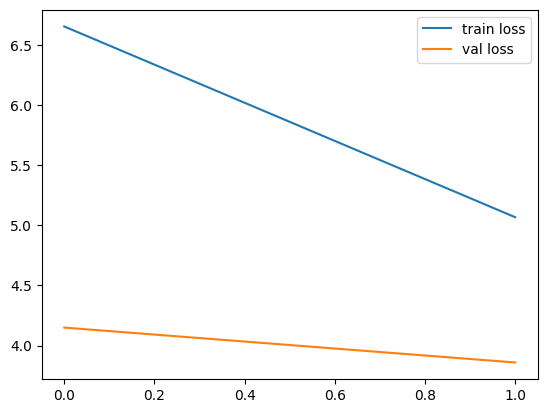

In [161]:
# plot loss
plt.plot(losses[0], label='train loss')
plt.plot(losses[1], label='val loss')
plt.legend()
plt.show()

## Test

In [ ]:
# predict
# Load pre-trained model and feature extractor
feature_extractor_i = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Tokenize input

image = []
with Image.open('Data/N24New/imgs/0.jpg') as img:
    img = img

Dưới đây là một ví dụ về phần abstract cho tập dữ liệu N24news:

"Tập dữ liệu N24news là một tập hợp lớn các bài báo tin tức từ kênh truyền thông N24. Tập dữ liệu này bao gồm hàng ngàn bài viết với một loạt các chủ đề, từ chính trị và kinh tế đến văn hóa và thể thao. Mỗi bài viết trong tập dữ liệu đều có tiêu đề, nội dung, ngày xuất bản, và tác giả (nếu có). Tập dữ liệu N24news là một nguồn tài nguyên quý giá cho các nghiên cứu về phân tích tin tức, xử lý ngôn ngữ tự nhiên, và học máy. Nó cung cấp một cái nhìn sâu sắc vào cách thông tin được truyền đạt trong tin tức và có thể được sử dụng để phát hiện xu hướng, mô hình, và đặc điểm khác của tin tức truyền thông."